# Field Validation

In [2]:

import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [3]:
#load data
df_data = pd.read_csv('../../data/test/Accelerometer_ziyi.csv') 
df_data

,Date,NTP,GNSS-Time,Acc-X,Acc-Y,Acc-Z
0,2025-03-28T16:00:44.931,2025-03-28 16:00:48.289,1743174048272,1.781281,4.735733,8.374924
1,2025-03-28T16:00:44.935,2025-03-28 16:00:48.293,1743174048276,2.643204,5.118805,8.274368
2,2025-03-28T16:00:44.942,2025-03-28 16:00:48.300,1743174048285,2.097321,5.037399,7.814682
3,2025-03-28T16:00:44.945,2025-03-28 16:00:48.303,1743174048286,1.891418,5.061340,8.034943
4,2025-03-28T16:00:44.951,2025-03-28 16:00:48.308,1743174048292,2.892197,5.272034,7.891296
...,...,...,...,...,...,...
268724,2025-03-28T16:22:59.273,2025-03-28 16:23:02.631,1743175382614,2.863464,5.655106,7.546524
268725,2025-03-28T16:22:59.277,2025-03-28 16:23:02.636,1743175382619,2.145203,5.549759,7.067688
268726,2025-03-28T16:22:59.284,2025-03-28 16:23:02.642,1743175382625,2.815582,5.281616,8.034943
268727,2025-03-28T16:22:59.288,2025-03-28 16:23:02.646,1743175382629,2.987961,5.559341,8.226471


In [4]:
df_curb = pd.read_csv('../../data/test/ESP_curb.csv')
df_curb

,Date,NTP,GNSS-Time,Value
0,2025-03-28T16:00:59.302,2025-03-28 16:01:02.660,1743174062643,Curb Up
1,2025-03-28T16:01:38.562,2025-03-28 16:01:41.920,1743174101903,Curb Up
2,2025-03-28T16:01:49.559,2025-03-28 16:01:52.917,1743174112903,Curb Up
3,2025-03-28T16:01:56.627,2025-03-28 16:01:59.985,1743174119969,Curb Up
4,2025-03-28T16:02:06.915,2025-03-28 16:02:10.274,1743174130257,Curb Up
...,...,...,...,...
135,2025-03-28T16:22:22.830,2025-03-28 16:22:26.188,1743175346171,Curb Up
136,2025-03-28T16:22:28.231,2025-03-28 16:22:31.589,1743175351572,Curb Up
137,2025-03-28T16:22:30.179,2025-03-28 16:22:33.537,1743175353520,Curb Up
138,2025-03-28T16:22:42.238,2025-03-28 16:22:45.596,1743175365579,Curb Up


In [6]:
#missing value
missing_info = handle_missing_values_length_index(df_data)
print(missing_info)
output = '../../data/test/Accelerometer_ziyi_filled_missing_values.csv'
fill_missing_values(df_data,output)
# check missing value
df_data.isnull().sum() 

No missing values longer than 100
{}


Date         0
NTP          0
GNSS-Time    0
Acc-X        0
Acc-Y        0
Acc-Z        0
dtype: int64

In [ ]:
# Get indices where curb_scene is 1
curb_indices = df_selected.index[df_selected['curb_scene'] == 1].tolist()

In [ ]:
def label_curb_scenes(df_data, df_curb, window_size=100):
    """
    Labels curb scenes in the data and extends labels to surrounding data points.
    
    Args:
        df_data (pd.DataFrame): Original dataframe containing NTP and Acc-Z data
        df_curb (pd.DataFrame): Dataframe containing curb timestamps
        window_size (int): Number of data points to label before and after each curb scene
        
    Returns:
        pd.DataFrame: DataFrame with labeled curb scenes
    """
    # Create copy with selected columns
    df_selected = df_data[['NTP', 'Acc-Z']].copy()
    df_selected['curb_scene'] = 0
    
    # Convert NTP columns to datetime
    df_selected['NTP'] = pd.to_datetime(df_selected['NTP'])
    df_curb['NTP'] = pd.to_datetime(df_curb['NTP'])
    
    # Find matching timestamps and label curb scenes
    df_selected.loc[df_selected['NTP'].isin(df_curb['NTP']), 'curb_scene'] = 1
    
    # Get indices where curb_scene is 1
    curb_indices = df_selected.index[df_selected['curb_scene'] == 1].tolist()
    
    # Extend labels to surrounding data points
    for idx in curb_indices:
        start_idx = max(0, idx - window_size)
        end_idx = min(len(df_selected) - 1, idx + window_size)
        df_selected.loc[start_idx:end_idx, 'curb_scene'] = 1
    
    return df_selected

In [12]:
df_selected = label_curb_scenes(df_data, df_curb)
print(df_selected.shape)
curb_indices = df_selected.index[df_selected['curb_scene'] == 1].tolist()
print(len(curb_indices))

(268729, 3)
5628


In [9]:
#segmentation
output = '../../data/test/Accelerometer_ziyi_segmented_time.csv'
segmented_test_data = segment_acceleration_data_no_overlapping_time_diff(df_selected,output)


In [10]:
segmented_test_data

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.504,2025-03-28 16:00:48.999,7.996628,8.092407,8.082825,8.030151,7.905655,8.001419,8.106766,...,8.006210,7.977478,7.963120,7.910446,7.939178,7.924805,7.867340,7.857773,7.824249,7.910446
1,0,2025-03-28 16:00:49.004,2025-03-28 16:00:49.495,7.900864,7.862564,7.829040,7.934387,7.953537,7.934387,7.771576,...,7.101196,7.201752,7.474701,7.489059,7.575256,7.369354,7.316681,7.354980,7.158661,7.398086
2,0,2025-03-28 16:00:49.500,2025-03-28 16:00:49.997,6.947967,7.445969,7.465118,7.364563,7.211334,7.498642,7.671021,...,8.001419,9.921570,10.596741,9.567230,8.772354,6.550537,5.501877,6.167465,5.995087,5.999863
3,0,2025-03-28 16:00:50.001,2025-03-28 16:00:50.498,7.915237,9.801865,10.682922,9.251190,8.250412,6.196198,6.742065,...,6.799530,9.011780,8.781937,8.983047,7.900864,9.840164,9.069229,8.623917,9.193741,8.954315
4,0,2025-03-28 16:00:50.503,2025-03-28 16:00:50.995,9.993393,7.987061,7.173035,7.407654,8.336609,8.178589,7.158661,...,9.610321,9.916779,9.327805,8.499420,8.638275,9.102753,9.097961,8.820236,8.628708,8.791504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,1,2025-03-28 16:21:11.503,2025-03-28 16:21:11.980,10.165787,10.893616,19.244598,13.962982,7.311890,0.905014,2.734177,...,8.159439,7.671021,9.835388,11.487381,7.402878,5.822693,8.705322,8.705322,8.705322,8.705322
2628,1,2025-03-28 16:21:31.501,2025-03-28 16:21:31.997,9.873688,6.780380,5.348648,6.608002,12.349289,13.594284,8.374924,...,8.135498,7.599197,10.031708,8.815445,7.173035,11.453857,12.583923,13.589493,6.751648,6.047760
2629,1,2025-03-28 16:22:14.073,2025-03-28 16:22:14.496,8.930374,9.940720,-2.504333,-4.510681,4.697418,22.261292,20.479996,...,11.104309,11.104309,11.104309,11.104309,11.104309,11.104309,11.104309,11.104309,11.104309,11.104309
2630,1,2025-03-28 16:22:14.501,2025-03-28 16:22:14.998,2.839523,3.351883,14.796173,17.994827,12.923904,-2.437302,-3.117249,...,21.030670,10.515335,-10.754761,-16.989258,-10.093948,1.331177,11.123459,6.268021,-2.422928,0.770935


In [13]:
# Show distribution of curb scenes
print("Distribution of curb scenes in segmented data:")
print(segmented_test_data['curb_scene'].value_counts())

# Calculate percentages
total_segments = len(segmented_test_data)
curb_segments = len(segmented_test_data[segmented_test_data['curb_scene'] == 1])
normal_segments = len(segmented_test_data[segmented_test_data['curb_scene'] == 0])

print("\nPercentages:")
print(f"Curb scenes: {(curb_segments/total_segments)*100:.2f}%")
print(f"Normal scenes: {(normal_segments/total_segments)*100:.2f}%")
print(f"\nTotal segments: {total_segments}")

Distribution of curb scenes in segmented data:
curb_scene
0    2594
1      38
Name: count, dtype: int64

Percentages:
Curb scenes: 1.44%
Normal scenes: 98.56%

Total segments: 2632


In [14]:
# standardize data
scaler = StandardScaler()
segmented_test_data_scaled = scaler.fit_transform(segmented_test_data.iloc[:, 3:])

In [15]:
# Load the three pre-trained models
import joblib  
autoencoder = tf.keras.models.load_model('../../models/autoencoder_handlebar_best.keras')
lstm_autoencoder = tf.keras.models.load_model('../../models/lstm_autoencoder_handlebar_best.keras')
one_class_svm = joblib.load('../../models/ocsvm_handlebar_best.joblib')

c:\Users\liuzi\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [45]:
print(segmented_test_data_scaled.shape)
# Reshape data for LSTM (add time step dimension)
segmented_test_data_scaled_lstm = np.reshape(segmented_test_data_scaled, 
                       (segmented_test_data_scaled.shape[0], 1, segmented_test_data_scaled.shape[1]))
print(segmented_test_data_scaled_lstm.shape)

(2632, 100)
(2632, 1, 100)


In [46]:
# Make predictions
autoencoder_pred = autoencoder.predict(segmented_test_data_scaled)
lstm_pred = lstm_autoencoder.predict(segmented_test_data_scaled_lstm)
svm_pred = one_class_svm.predict(segmented_test_data_scaled)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


c:\Users\liuzi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


In [58]:
# Calculate reconstruction errors for autoencoder and LSTM
autoencoder_errors = np.mean(np.abs(autoencoder_pred - segmented_test_data_scaled), axis=1)
lstm_errors = np.mean(np.abs(lstm_pred.reshape(lstm_pred.shape[0], -1) - segmented_test_data_scaled), axis=1)

# Define thresholds for autoencoders (you may need to adjust these values)
autoencoder_threshold = np.mean(autoencoder_errors) + 3 * np.std(autoencoder_errors)
lstm_threshold = np.mean(lstm_errors) + 3 * np.std(lstm_errors)

# Convert reconstruction errors to binary predictions (1 for anomaly, 0 for normal)
autoencoder_anomalies = (autoencoder_errors > autoencoder_threshold).astype(int)
lstm_anomalies = (lstm_errors > lstm_threshold).astype(int)
# SVM predictions are already binary (-1 for anomaly, 1 for normal), convert to 0/1
svm_anomalies = (svm_pred == -1).astype(int)

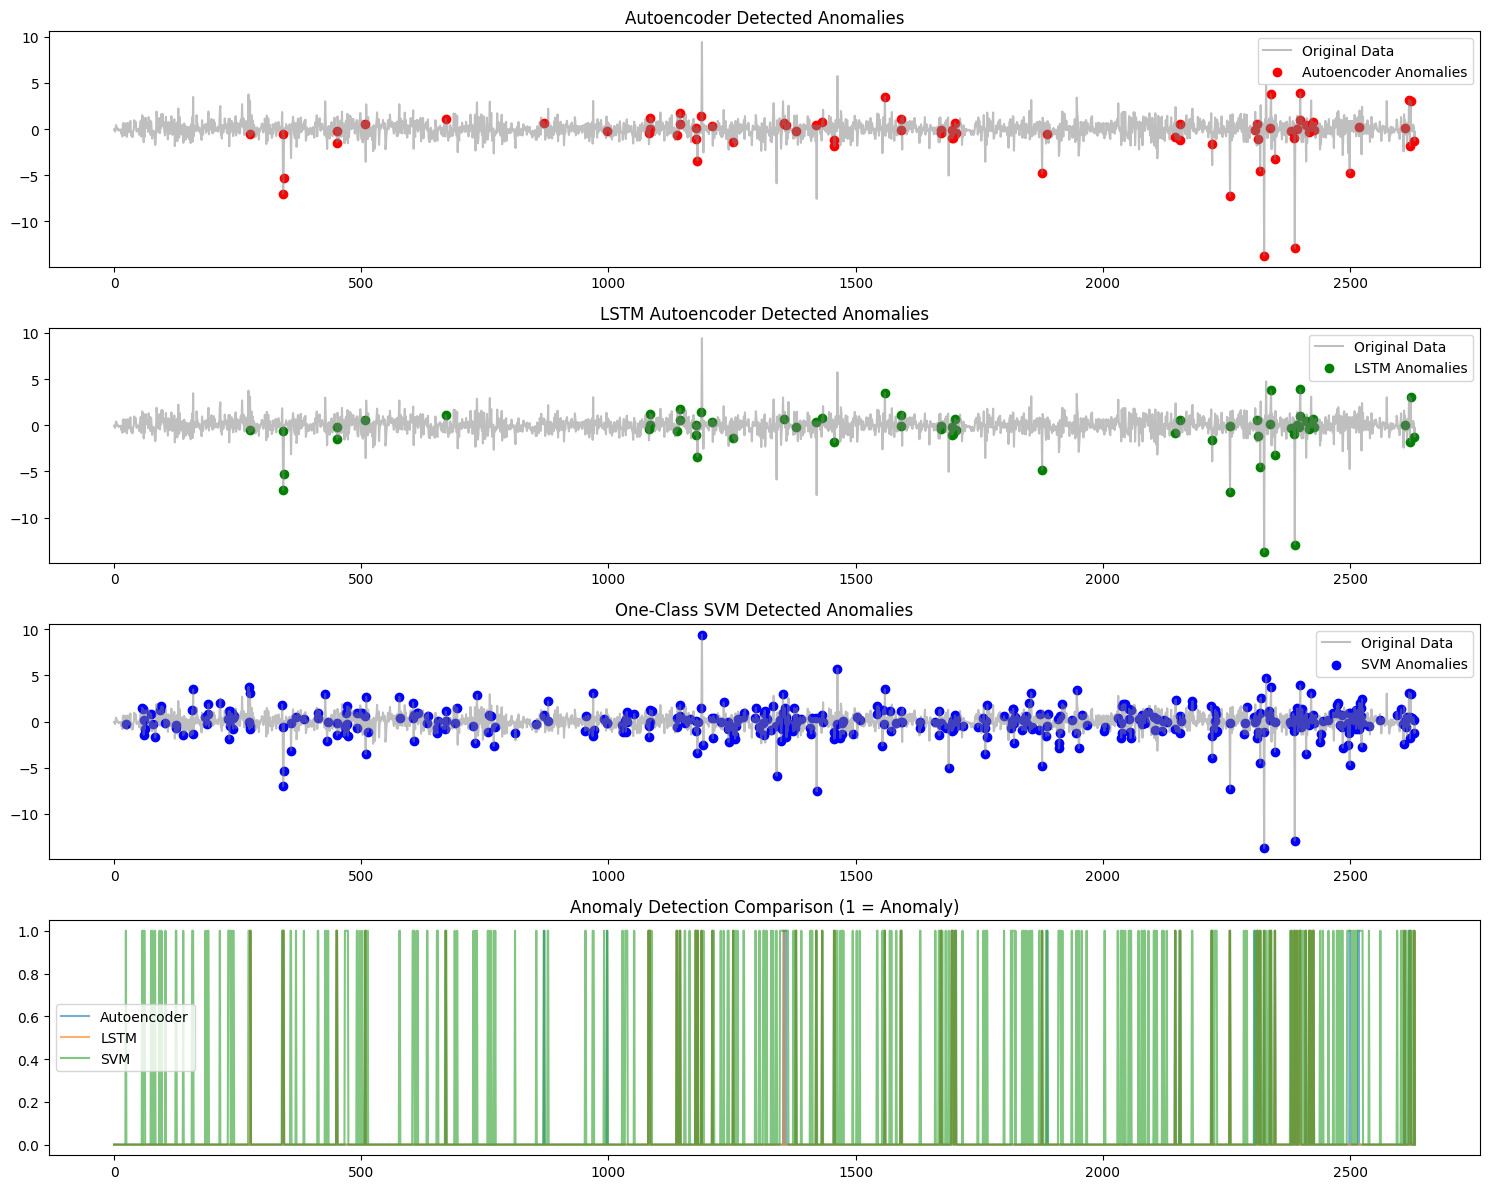


Anomaly Detection Statistics:
Autoencoder detected: 74 anomalies
LSTM detected: 65 anomalies
SVM detected: 423 anomalies

All three models agreed on 63 anomalies


In [59]:
# Create visualization
plt.figure(figsize=(15, 12))

# Plot 1: Original data with Autoencoder anomalies
plt.subplot(4, 1, 1)
plt.plot(segmented_test_data_scaled[:, 0], color='gray', alpha=0.5, label='Original Data')
plt.scatter(np.where(autoencoder_anomalies == 1)[0], 
           segmented_test_data_scaled[autoencoder_anomalies == 1, 0],
           color='red', label='Autoencoder Anomalies')
plt.title('Autoencoder Detected Anomalies')
plt.legend()

# Plot 2: Original data with LSTM anomalies
plt.subplot(4, 1, 2)
plt.plot(segmented_test_data_scaled[:, 0], color='gray', alpha=0.5, label='Original Data')
plt.scatter(np.where(lstm_anomalies == 1)[0], 
           segmented_test_data_scaled[lstm_anomalies == 1, 0],
           color='green', label='LSTM Anomalies')
plt.title('LSTM Autoencoder Detected Anomalies')
plt.legend()

# Plot 3: Original data with SVM anomalies
plt.subplot(4, 1, 3)
plt.plot(segmented_test_data_scaled[:, 0], color='gray', alpha=0.5, label='Original Data')
plt.scatter(np.where(svm_anomalies == 1)[0], 
           segmented_test_data_scaled[svm_anomalies == 1, 0],
           color='blue', label='SVM Anomalies')
plt.title('One-Class SVM Detected Anomalies')
plt.legend()

# Plot 4: Comparison of all detections
plt.subplot(4, 1, 4)
plt.plot(autoencoder_anomalies, label='Autoencoder', alpha=0.6)
plt.plot(lstm_anomalies, label='LSTM', alpha=0.6)
plt.plot(svm_anomalies, label='SVM', alpha=0.6)
plt.title('Anomaly Detection Comparison (1 = Anomaly)')
plt.legend()

plt.tight_layout()
plt.show()

# Print detection statistics
print("\nAnomaly Detection Statistics:")
print(f"Autoencoder detected: {np.sum(autoencoder_anomalies)} anomalies")
print(f"LSTM detected: {np.sum(lstm_anomalies)} anomalies")
print(f"SVM detected: {np.sum(svm_anomalies)} anomalies")

# Show agreement between models
agreement = np.sum((autoencoder_anomalies & lstm_anomalies & svm_anomalies))
print(f"\nAll three models agreed on {agreement} anomalies")